Importing the necessary library files

In [1]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from PIL import Image
import sys

Loading TransCG Dataset from Google Drive

In [3]:
path_to_dataset = "drive//MyDrive//M202A//transcg//"

config={"path":path_to_dataset,"all_files":[]}
def extract_files(config):
  path = config["path"]
  all_files = config["all_files"]
  for (path,directory,files) in tqdm(os.walk(path)):
    if(files!=[]):
      files= [path+"//"+i for i in files]
      if((path+"//rgb2.png" in files) and(path+"//depth2-gt.png" in files) and (path+"//depth2-gt-mask.png") and (path+"//depth2.png" in files)):
          all_files.append(files)


extract_files(config)

def load_files(config):
  filepaths = config["all_files"]
  length = len(filepaths)
  batchsize = length//6
  indices = np.random.randint(low=0,high=length,size=batchsize)
  color = np.zeros((batchsize,1280,720,3)).astype(np.uint8)
  rawdepth = np.zeros((batchsize,1280,720)).astype(np.float32)
  groundtruth = np.zeros_like(rawdepth).astype(np.float32)
  depthmasks = np.zeros_like(rawdepth).astype(np.uint8)
  pbar = tqdm(total=batchsize)
  count = 0
  for idx in indices:
    files = filepaths[idx]
    for f in files:
      if("rgb2.png" in f):
        color[count,...] = np.asarray(Image.open(f)).transpose(1,0,2)
      elif("depth2-gt-mask.png" in f):
        depthmasks[count,...] = np.asarray(Image.open(f)).astype(np.uint8).T
      elif("depth2-gt.png" in f):
        groundtruth[count,...] = np.asarray(Image.open(f)).astype(np.float32).T
      elif("depth2.png" in f):
        rawdepth[count,...] = np.asarray(Image.open(f)).astype(np.float32).T
    pbar.update(1)
    count+=1
  config["color"] = color
  config["depth"] = groundtruth
  config["rawDepth"] = rawdepth
  config["validmasks"]= depthmasks

load_files(config)


1921it [02:18, 13.89it/s]
100%|██████████| 318/318 [16:58<00:00,  3.20s/it]


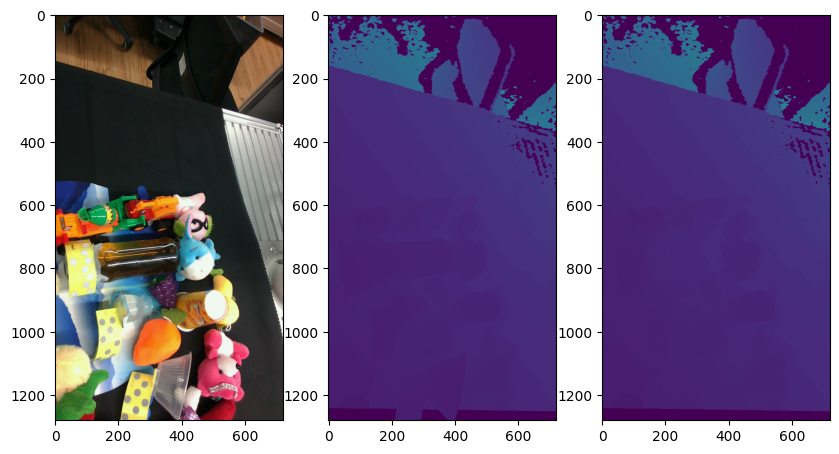

In [4]:
%matplotlib inline
fig,axs = plt.subplots(1,3,figsize=(10,10))
color = config["color"]
axs[0].imshow(color[0].astype(np.uint8))

depth = config["depth"]
axs[1].imshow(depth[0])
rawdepth = config["rawDepth"]
axs[2].imshow(rawdepth[0])



In [5]:
!git clone https://github.com/VCL3D/DeepDepthDenoising

Cloning into 'DeepDepthDenoising'...
remote: Enumerating objects: 394, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 394 (delta 22), reused 46 (delta 22), pack-reused 345
Receiving objects: 100% (394/394), 6.33 MiB | 20.71 MiB/s, done.
Resolving deltas: 100% (153/153), done.


In [6]:
sys.path.insert(1, 'DeepDepthDenoising/')
!pip install visdom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408194 sha256=84b121efb02bfabec193eabd022bb61ccfadbc612d778b6c6b6cca413138c15d
  Stored in directory: /root/.cache/pip/wheels/42/29/49/5bed207bac4578e4d2c0c5fc0226bfd33a7e2953ea56356855
Successfully built visdom


In [7]:
import models
import utils
import importers
from supervision import *
from exporters import *
from importers import *

/content/DeepDepthDenoising/supervision/normals.py:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if policy is "upright":


In [8]:
dddpath = "drive/MyDrive/M202A/ddd"

In [9]:
model_params = {
        'width': 720,
        'height': 1280,
        'ndf': 8,
        'dilation': 1,
        'norm_type': "elu",
        'upsample_type': "nearest"
    }

model = models.get_model(model_params).to("cuda")
utils.init.initialize_weights(model,dddpath)
uv_grid_t =  create_image_domain_grid(model_params['width'], model_params['height'])

Passing through NN

In [10]:
length = len(color)
error = []
denoised_depth_images = np.zeros_like(rawdepth)
for i in tqdm(range(length)):
    rawD = torch.tensor(rawdepth[i],dtype=torch.float).to("cuda")*2.5e-4
    rawD = rawD.reshape(1,1,1280,720)
    mask,_ = get_mask(rawD)
    predicted_depth,_ = model(rawD,mask)
    masked_predicted_depth = predicted_depth*mask
    gt = depth[i]
    gt_tensor = torch.tensor(gt,dtype=torch.float).to("cuda")*2.5e-4
    loss = (masked_predicted_depth-gt_tensor*mask).to("cpu").detach().numpy()
    denoised_depth_images[i,...] = predicted_depth.to("cpu").detach().numpy()
    error.append(loss)


100%|██████████| 318/318 [00:21<00:00, 14.90it/s]


Measure the MSE, by masking

Average mean squared error is  11.016067117452621
Average root mean squared error is  37.78837248682976


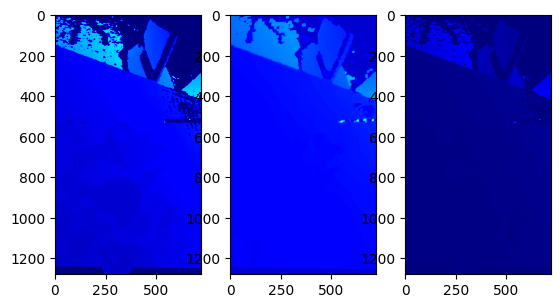

In [12]:
mae = [np.mean(abs(i)) for i in error]
rmse = [np.sqrt(np.mean(i**2)) for i in error]
print("Average mean squared error is ",np.mean(mae)*1000)
print("Average root mean squared error is ",np.mean(rmse)*1000)

random_indice = np.random.randint(low=0,high = len(mae))
denoised_image = denoised_depth_images[random_indice]
mean_squared_error = (depth[random_indice] - denoised_image)**2
fig,axs = plt.subplots(1,3)
axs[0].imshow(depth[random_indice],cmap="jet")
axs[1].imshow(denoised_image,cmap="jet")
axs[2].imshow(mean_squared_error,cmap='jet')

plt.show()

BiLateral Filtering

100%|██████████| 318/318 [00:06<00:00, 45.93it/s]


Average MAE is  21.267471835017204
Average root mean squared error is  84.89895612001419


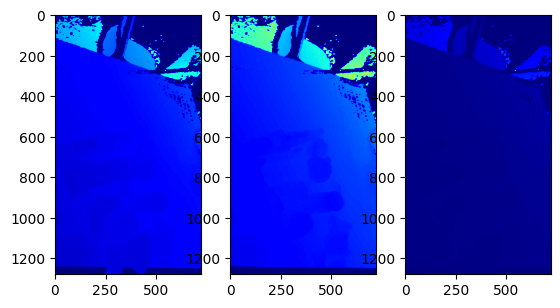

In [13]:
length = len(color)
error = []

denoised_depth_images = np.zeros_like(rawdepth)
for i in tqdm(range(length)):
  denoised_depth_images[i,...] = cv2.bilateralFilter(rawdepth[i]*2.5e-4,5,150,150)
  validity_mask = rawdepth[i]>0
  error.append((depth[i][validity_mask]*2.5e-4-denoised_depth_images[i][validity_mask]))

mae = [np.mean(abs(i)) for i in error]
rmse = [np.sqrt(np.mean(i**2)) for i in error]
print("Average MAE is ",np.mean(mae)*1000)
print("Average root mean squared error is ",np.mean(rmse)*1000)

random_indice = np.random.randint(low=0,high = len(mae))
denoised_image = denoised_depth_images[random_indice]
mean_squared_error = (depth[random_indice] - denoised_image)**2
fig,axs = plt.subplots(1,3)
axs[0].imshow(depth[random_indice],cmap="jet")
axs[1].imshow(denoised_image,cmap="jet")
axs[2].imshow(mean_squared_error,cmap='jet')

Isotropic Diffusion

In [14]:
def anisodiff(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False):
	"""
	Anisotropic diffusion.

	Usage:
	imgout = anisodiff(im, niter, kappa, gamma, option)

	Arguments:
	        img    - input image
	        niter  - number of iterations
	        kappa  - conduction coefficient 20-100 ?
	        gamma  - max value of .25 for stability
	        step   - tuple, the distance between adjacent pixels in (y,x)
	        option - 1 Perona Malik diffusion equation No 1
	                 2 Perona Malik diffusion equation No 2
	        ploton - if True, the image will be plotted on every iteration

	Returns:
	        imgout   - diffused image.

	kappa controls conduction as a function of gradient.  If kappa is low
	small intensity gradients are able to block conduction and hence diffusion
	across step edges.  A large value reduces the influence of intensity
	gradients on conduction.

	gamma controls speed of diffusion (you usually want it at a maximum of
	0.25)

	step is used to scale the gradients in case the spacing between adjacent
	pixels differs in the x and y axes

	Diffusion equation 1 favours high contrast edges over low contrast ones.
	Diffusion equation 2 favours wide regions over smaller ones.

	Reference:
	P. Perona and J. Malik.
	Scale-space and edge detection using ansotropic diffusion.
	IEEE Transactions on Pattern Analysis and Machine Intelligence,
	12(7):629-639, July 1990.

	Original MATLAB code by Peter Kovesi
	School of Computer Science & Software Engineering
	The University of Western Australia
	pk @ csse uwa edu au
	<http://www.csse.uwa.edu.au>

	Translated to Python and optimised by Alistair Muldal
	Department of Pharmacology
	University of Oxford
	<alistair.muldal@pharm.ox.ac.uk>

	June 2000  original version.
	March 2002 corrected diffusion eqn No 2.
	July 2012 translated to Python
	"""

	# ...you could always diffuse each color channel independently if you
	# really want
	if img.ndim == 3:
		warnings.warn("Only grayscale images allowed, converting to 2D matrix")
		img = img.mean(2)

	# initialize output array
	img = img.astype('float32')
	imgout = img.copy()

	# initialize some internal variables
	deltaS = np.zeros_like(imgout)
	deltaE = deltaS.copy()
	NS = deltaS.copy()
	EW = deltaS.copy()
	gS = np.ones_like(imgout)
	gE = gS.copy()

	# create the plot figure, if requested
	if ploton:
		import pylab as pl
		from time import sleep

		fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
		ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

		ax1.imshow(img,interpolation='nearest')
		ih = ax2.imshow(imgout,interpolation='nearest',animated=True)
		ax1.set_title("Original image")
		ax2.set_title("Iteration 0")

		fig.canvas.draw()

	for ii in np.arange(1,niter):

		# calculate the diffs
		deltaS[:-1,: ] = np.diff(imgout,axis=0)
		deltaE[: ,:-1] = np.diff(imgout,axis=1)

		if 0<sigma:
			deltaSf=flt.gaussian_filter(deltaS,sigma);
			deltaEf=flt.gaussian_filter(deltaE,sigma);
		else:
			deltaSf=deltaS;
			deltaEf=deltaE;

		# conduction gradients (only need to compute one per dim!)
		if option == 1:
			gS = np.exp(-(deltaSf/kappa)**2.)/step[0]
			gE = np.exp(-(deltaEf/kappa)**2.)/step[1]
		elif option == 2:
			gS = 1./(1.+(deltaSf/kappa)**2.)/step[0]
			gE = 1./(1.+(deltaEf/kappa)**2.)/step[1]

		# update matrices
		E = gE*deltaE
		S = gS*deltaS

		# subtract a copy that has been shifted 'North/West' by one
		# pixel. don't as questions. just do it. trust me.
		NS[:] = S
		EW[:] = E
		NS[1:,:] -= S[:-1,:]
		EW[:,1:] -= E[:,:-1]

		# update the image
		imgout += gamma*(NS+EW)

		if ploton:
			iterstring = "Iteration %i" %(ii+1)
			ih.set_data(imgout)
			ax2.set_title(iterstring)
			fig.canvas.draw()
			# sleep(0.01)

	return imgout



In [15]:
import warnings

In [16]:
length = len(color)
error = []

denoised_depth_images = np.zeros_like(rawdepth)
for i in tqdm(range(length)):
  denoised_depth_images[i,...] = anisodiff(rawdepth[i].astype(np.float32)*2.5e-4,niter=200)
  validity_mask = rawdepth[i]>0
  error.append((depth[i][validity_mask]*2.5e-4-denoised_depth_images[i][validity_mask]))

100%|██████████| 318/318 [13:52<00:00,  2.62s/it]


Average MAE is  49.433715641498566
Average root mean squared error is  170.39091885089874


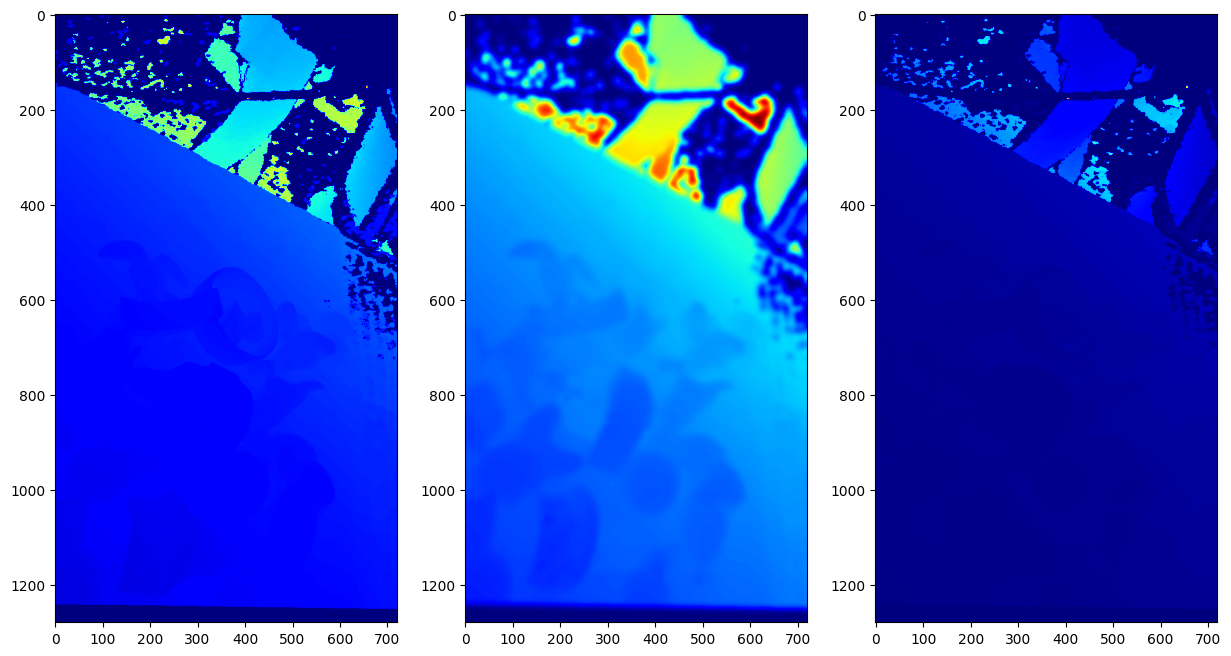

In [17]:
mae = [np.mean(abs(i)) for i in error]
rmse = [np.sqrt(np.mean(i**2)) for i in error]
print("Average MAE is ",np.mean(mae)*1000)
print("Average root mean squared error is ",np.mean(rmse)*1000)

random_indice = np.random.randint(low=0,high = len(mae))
denoised_image = denoised_depth_images[random_indice]
mean_squared_error = (depth[random_indice] - denoised_image)**2
fig,axs = plt.subplots(1,3,figsize=(15,15))

axs[0].imshow(depth[random_indice],cmap="jet")
axs[1].imshow(denoised_image,cmap="jet")
axs[2].imshow(mean_squared_error,cmap='jet')